In [416]:
import numpy as np
import numpy.linalg as LA
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import pickle # for hacky deep copy
import random
random.seed(2705)

In [417]:

rows_count = 10
columns_count = 10
terminating = [(rows_count-1, columns_count-1)]
DOOR = "D"
START = "S"
EMPTY = "E"
WALL = "W"
KEYS = "K"
PATH = "P"
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
stepcost = -1

def generateTestMaze():
    V = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
    V.fillna(EMPTY, inplace=True)
    V.iloc[0][1] = WALL
    V.iloc[1][1] = WALL
    V.iloc[2][1] = WALL
    
    V.iloc[4][0] = WALL
    V.iloc[4][1] = WALL
    V.iloc[4][2] = WALL
    V.iloc[4][3] = WALL
    
    V.iloc[7][0] = WALL
    V.iloc[7][1] = WALL
    V.iloc[7][2] = WALL
    V.iloc[7][4] = WALL
    V.iloc[7][5] = WALL
    V.iloc[7][6] = WALL
    
    V.iloc[0][7] = WALL
    V.iloc[1][7] = WALL
    V.iloc[2][7] = WALL
    V.iloc[3][7] = WALL
    V.iloc[4][7] = WALL
    V.iloc[5][7] = WALL
    V.iloc[6][7] = WALL
    

    V.iloc[rows_count-1][columns_count-1] = DOOR
    V.iloc[0][0] = START
    return V
    

maze = generateTestMaze()
print(maze)

   0  1  2  3  4  5  6  7  8  9
0  S  W  E  E  E  E  E  W  E  E
1  E  W  E  E  E  E  E  W  E  E
2  E  W  E  E  E  E  E  W  E  E
3  E  E  E  E  E  E  E  W  E  E
4  W  W  W  W  E  E  E  W  E  E
5  E  E  E  E  E  E  E  W  E  E
6  E  E  E  E  E  E  E  W  E  E
7  W  W  W  E  W  W  W  E  E  E
8  E  E  E  E  E  E  E  E  E  E
9  E  E  E  E  E  E  E  E  E  D


(100, 40, 40, 3)


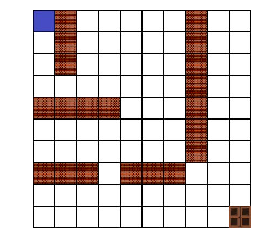

In [418]:
def arrayToImage(array, ncols=10):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result


def makeImageArray(dataframe):
    imageArray = np.array([np.asarray(Image.open('images/path.jpg').convert('RGB'))])
    for i in range(rows_count):
        for j in range(columns_count):
            #skip the first cell, since we already add it in the begining
            if (i!=0) or (j!=0):                
                path = "images/empty.jpg"
                if dataframe.iloc()[i][j] == WALL:
                    path = "images/wall.jpg"
                elif dataframe.iloc()[i][j] == DOOR:
                    path = "images/door.jpg"
                elif dataframe.iloc()[i][j] == PATH:
                    path = "images/path.jpg"
                elif dataframe.iloc()[i][j] == KEYS:
                    path = "images/key"
                imageArray = np.append(imageArray, [np.asarray(Image.open(path).convert('RGB'))], axis=0)
    return imageArray

def showMaze(array):
    print(array.shape)
    result = arrayToImage(array)
    plt.imshow(result)
    plt.axis('off')
    plt.show()

array = makeImageArray(maze)
showMaze(array)

In [419]:
gamma = 1
alpha = 0.2
episode = 4000
maxStep = 4000
epsilon = 0.5

def epsilon_greedy(Q, epsilon, row, column):
    if np.random.rand() < epsilon:
        actIndex = Q.iloc()[row][column].index(max(Q.iloc()[row][column]))        
    else:
        actIndex = random.choice([UP, DOWN, LEFT, RIGHT])    
    
    return actIndex

def valueForMaze(row, column, action, maze): 
    """
    @param row
    @param column
    @param action
    @param maze
    
    Make sure that the action don't make you step out of the array bondary [0, rows_count-1] or [0, columns_count-1]
    Some codes look like it doesn't do anything (actionColumn = max(column, 0)), but it actually does something
    in other scenario (column was change because of "Wind blow left", so just leave it there)
    """
    if (row,column) in terminating:
        return 0, 0, 0    
    else:        
        if (action == UP):
            actionRow = max(min(row-1, rows_count-1), 0)
            actionColumn = max(min(column, columns_count-1),0)
        elif (action == DOWN) :
            actionRow = max(min(row+1, rows_count-1),0)
            actionColumn = max(min(column, columns_count-1),0)
        elif (action == LEFT) :
            actionRow = max(min(row, rows_count-1),0)
            actionColumn = max(column-1, 0)
        elif (action == RIGHT) :
            actionRow = max(min(row, rows_count-1),0)
            actionColumn = max(min(column+1, columns_count-1),0)
        
        #Check if step into wall
        if (maze.iloc()[actionRow][actionColumn]) == "W":
            return stepcost, row, column
        else:
            return stepcost, actionRow, actionColumn

#Initialize Q(s,a):
Q = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
for i in range(rows_count):
    for j in range (columns_count):
        Q.iloc()[i][j] = [0, 0, 0, 0]
                            
                            
for i in tqdm(range(episode)):
    #initialize stage S:
    row = random.randint(0, rows_count-1)
    column = random.randint(0, columns_count-1)
                            
    #If the result is wall, do it again
    while (maze.iloc()[row][column] == "W"):
        row = random.randint(0, rows_count-1)
        column = random.randint(0, columns_count-1)                            
    
    step = 1
    #Choose action A from state S using policy derived from Q (e.g., epsilon-greedy)
    action = epsilon_greedy(Q, epsilon, row, column)
    
    while(True):
        #Until S is terminal
        if (row,column) in terminating:
            break
        
        #Take action A, observe R (reward) and new state S':
        reward, newRow, newColumn = valueForMaze(row, column, action, maze)
        
        #Choose action A' from state S' using policy derived from Q (e.g., epsilon-greedy)
        newAction = epsilon_greedy(Q, epsilon, newRow, newColumn)        
        
        #Q(S,A) <- Q(S,A) + alpha*[R + gamma*Q(S',A') - Q(S,A)]
        Q.iloc()[row][column][action] = Q.iloc()[row][column][action] +\
            alpha*(reward + gamma*Q.iloc()[newRow][newColumn][newAction] - Q.iloc()[row][column][action])
        row = newRow
        column = newColumn
        action = newAction
        step+=1


100%|██████████| 4000/4000 [01:32<00:00, 43.11it/s]


(100, 40, 40, 3)


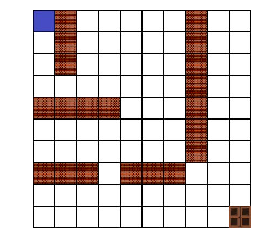

       0      1      2      3      4      5      6      7      8      9
0   DOWN     UP   DOWN  RIGHT     UP   DOWN  RIGHT     UP   DOWN   DOWN
1   DOWN     UP  RIGHT  RIGHT   DOWN   DOWN   DOWN     UP   DOWN   DOWN
2   DOWN     UP   DOWN  RIGHT   DOWN   DOWN   DOWN     UP   DOWN   DOWN
3  RIGHT  RIGHT  RIGHT  RIGHT   DOWN   DOWN   DOWN     UP   DOWN   DOWN
4     UP     UP     UP     UP   DOWN   DOWN   LEFT     UP   DOWN   DOWN
5  RIGHT  RIGHT   DOWN   DOWN   LEFT   LEFT   DOWN     UP   DOWN   DOWN
6  RIGHT  RIGHT  RIGHT   DOWN   LEFT   LEFT   LEFT     UP   DOWN   DOWN
7     UP     UP     UP   DOWN     UP     UP     UP   DOWN  RIGHT   DOWN
8  RIGHT  RIGHT  RIGHT   DOWN  RIGHT  RIGHT  RIGHT  RIGHT  RIGHT   DOWN
9  RIGHT  RIGHT  RIGHT  RIGHT  RIGHT  RIGHT  RIGHT  RIGHT  RIGHT  --X--


In [420]:
V = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
ACTION_LIST = ["UP", "DOWN", "LEFT", "RIGHT"]

for i in range(rows_count):
    for j in range (columns_count):
        actIndex = Q.iloc()[i][j].index(max(Q.iloc()[i][j]))
        V.iloc()[i][j] = ACTION_LIST[actIndex]

V.iloc()[terminating[0][0]][terminating[0][1]] = "--X--"    
showMaze(array)
print(V)

In [427]:
def generateResultMaze(qDF, baseMaze):
    myMaze = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
    myMaze.fillna(EMPTY, inplace=True)
    row = 0
    column = 0
    
    maxLength = rows_count*columns_count*10
    step = 0
    
    #Put in the correct path
    while (((row,column) not in terminating) and (step < maxLength)):
        actIndex = qDF.iloc()[row][column].index(max(qDF.iloc()[row][column]))        
        if (actIndex == 0):
            row = max(row - 1, 0)
        elif (actIndex == 1):
            row = row + 1
        elif (actIndex == 2):
            column = max(column - 1, 0)
        else:
            column = column + 1
        myMaze.iloc()[row][column] = PATH
        step = step + 1
        if (step==maxLength):
            print("Failed to find the exit after walk for {} times".format(step))
    
    #Put in the wall
    for i in range(rows_count):
        for j in range (columns_count):
            if (baseMaze.iloc()[i][j] == WALL):
                myMaze.iloc()[i][j] = WALL                
    return myMaze


(100, 40, 40, 3)


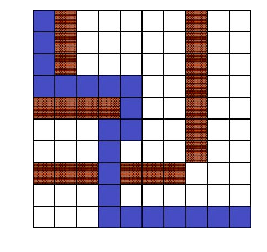

In [429]:
resultMaze = generateResultMaze(Q, maze)
resultArray = makeImageArray(resultMaze)
showMaze(resultArray)